### Import relevant packages

In [641]:
import numpy as np
import cv2
#from utilities import *
import torchfile as tr
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
from datetime import datetime
%matplotlib inline
import math
import pandas as pd

### Load training and test data

In [642]:
train_data = tr.load('../data.bin')
test_data = tr.load('../test.bin')
train_labels=tr.load('../labels.bin')

In [643]:
print("Training data shape :{}".format(train_data.shape))
print("Testing data shape :{}".format(test_data.shape))
print("Training label data shape :{}".format(train_labels.shape))

Training data shape :(29160, 108, 108)
Testing data shape :(29160, 108, 108)
Training label data shape :(29160,)


### Split train data to train and val data

In [644]:
from sklearn.model_selection import train_test_split
test_x,valid_x,test_y,valid_y=train_test_split(train_data,train_labels,test_size=0.2,random_state=0)

### Image plot for data Visualization

In [645]:
index=14
img=train_data[index]

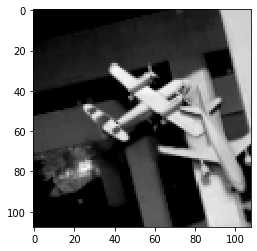

In [646]:
plt.imshow(img,cmap='gray')

### Reshaping training and test data

In [647]:
#Reshaping training data to (108*108,29160)
train_data=test_x.reshape(test_x.shape[0],-1).T
validation_data=valid_x.reshape(valid_x.shape[0],-1).T

In [648]:
#Reshaping test data to shape (108*108,29160)
test_data=test_data.reshape(test_data.shape[0],-1).T

In [649]:
#Reshaping train labels to (29160,1)
train_labels=test_y.reshape(test_y.shape[0],-1).T
validation_labels=valid_y.reshape(valid_y.shape[0],-1).T

In [650]:
train_labels_acc=np.copy(train_labels)

### Convert Lables to one hot vectors

In [651]:
train_labels=np.squeeze(np.eye(6)[train_labels]).T
#validation_labels=np.squeeze(np.eye(6)[validation_labels]).T

In [652]:
print("Training data shape after Reshape:{}".format(train_data.shape))
print("Training label data shape after Reshape:{}".format(train_labels.shape))
print("Testing data shape after Reshape:{}".format(test_data.shape))

Training data shape after Reshape:(11664, 23328)
Training label data shape after Reshape:(6, 23328)
Testing data shape after Reshape:(11664, 29160)


## Defining Network Architecture

### Weight Initialization

In [687]:
def initialization(layer_dims):
    #np.random.seed(3)
    #no_of_layers = len(layer_dims)-1
    #parameters ={}
    #for l in range(1, no_of_layers + 1):
    #    parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01 #*np.sqrt(2./layer_dims[l-1])
    #    parameters["b"+str(l)]=np.zeros(shape=(layer_dims[l],1))
    #parameters=np.load('parameters.npy',allow_pickle=True)
    #print('parameters==',len(parameters))
    # Load data (deserialize)
    with open('parameters_15-11-2019_09-38-04_AM.pickle', 'rb') as handle:
        parameters = pickle.load(handle)
    #print('parameters==',len(parameters))
    return parameters

### Define Mini Batches

In [654]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, (k+1)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (k+1)*mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Utility Functions

In [655]:
def relu_forward(Z):
    A=np.maximum(0,Z)
    return A,Z

In [656]:
def relu_backward(prev_der,saved_data):
    this_layer_activation=saved_data  #saved_data=Z of this layer
    d_this_layer=np.array(prev_der, copy=True)
    #print("d of thsi layer===",d_this_layer)
    d_this_layer[this_layer_activation <=0 ]=0
    #print("d of thsi layer===",d_this_layer)
    return d_this_layer

In [657]:
def softmax_forward(Z):
    exp=np.exp(Z)
    sum_exp=np.sum(exp,axis=0,keepdims=True)
    softmax=exp/sum_exp
    #Z -= np.max(Z)
    #softmax = (np.exp(Z).T / np.sum(np.exp(Z),axis=1)).T
    return softmax,Z

### Forward Propogation

In [658]:
def linear_plus_activation(X,W,b,activation):
    Z = np.dot(W,X)+b
    
    if activation=="relu":
        A,activation_save_data=relu_forward(Z)
    else:
        A,activation_save_data=softmax_forward(Z)
    linear_save_data=(X,W,b)
    save_data=(linear_save_data,activation_save_data)
    return A,save_data

In [659]:
def forward_prop(X,parameters):    
    A=X
    cache_data=[]
    #no of layers
    L=len(parameters)//2  #W and b so //2
    for l in range(1,L):
        A_prev=A
        A ,relu_save_data= linear_plus_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        cache_data.append(relu_save_data)
    A_final ,softmax_save_data= linear_plus_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"softmax")
    cache_data.append(softmax_save_data)
    return A_final,cache_data
        

### Backward propogation

In [660]:
def backward_gradient_compute_linear(grad_from_top_layer,save_data,activation):
    linear_saved_data,activation_saved_data=save_data
    total_images=grad_from_top_layer.shape[1]
    if activation=="relu":
        grad_from_top=relu_backward(grad_from_top_layer,activation_saved_data)
    prev_activation,W,b=linear_saved_data
    #print("top grad==",grad_from_top)
    dW=np.dot(grad_from_top,prev_activation.T)/total_images
    db=np.sum(grad_from_top,axis=1,keepdims=True)/total_images
    d_pass_to_prev_layer=np.dot(W.T,grad_from_top)
    #print("dw==",dW)
    return d_pass_to_prev_layer,dW,db
    
    

In [661]:
def backward_gradient_compute_linear_with_regularization(grad_from_top_layer,save_data,activation,lambd):
    linear_saved_data,activation_saved_data=save_data
    total_images=grad_from_top_layer.shape[1]
    if activation=="relu":
        grad_from_top=relu_backward(grad_from_top_layer,activation_saved_data)
    prev_activation,W,b=linear_saved_data
    #print("top grad==",grad_from_top)
    dW=np.dot(grad_from_top,prev_activation.T)/total_images+lambd*W/total_images
    db=np.sum(grad_from_top,axis=1,keepdims=True)/total_images
    d_pass_to_prev_layer=np.dot(W.T,grad_from_top)
    #print("dw==",dW)
    return d_pass_to_prev_layer,dW,db

In [662]:
def backward_prop(output_from_softmax,Y,saved_data):
    gradients={}
    prev_derivate=output_from_softmax-Y
    
    number_of_layers=len(saved_data)
    total_images=Y.shape[1]
    final_layer_saved=saved_data[number_of_layers-1]
    linear,activation=final_layer_saved
    gradients['dW'+str(number_of_layers)]=np.dot(prev_derivate,linear[0].T)/total_images
    gradients['db'+str(number_of_layers)]=np.sum(prev_derivate,axis=1,keepdims=True)/total_images
    prev_derivate=np.dot(linear[1].T,prev_derivate)
    for l in reversed(range(number_of_layers-1)):
        current_layer_save_data=saved_data[l]
        prev_derivate,dW,db=backward_gradient_compute_linear(prev_derivate,current_layer_save_data,"relu")
        gradients['dW'+str(l+1)]=dW
        gradients['db'+str(l+1)]=db
        #print("gradient shapes of W{0}:{1} and b{2}:{3}".format(l,dW.shape,l,db.shape))
    #print("dW1===",gradients["dW1"])
    return gradients
        
        
    

In [663]:
def backward_prop_with_regularization(output_from_softmax,Y,saved_data,lambd):
    gradients={}
    prev_derivate=output_from_softmax-Y
    
    number_of_layers=len(saved_data)
    total_images=Y.shape[1]
    final_layer_saved=saved_data[number_of_layers-1]
    linear,activation=final_layer_saved
    gradients['dW'+str(number_of_layers)]=np.dot(prev_derivate,linear[0].T)/total_images+lambd*linear[1]/total_images
    gradients['db'+str(number_of_layers)]=np.sum(prev_derivate,axis=1,keepdims=True)/total_images
    prev_derivate=np.dot(linear[1].T,prev_derivate)
    for l in reversed(range(number_of_layers-1)):
        current_layer_save_data=saved_data[l]
        prev_derivate,dW,db=backward_gradient_compute_linear_with_regularization(prev_derivate,current_layer_save_data,"relu",lambd)
        gradients['dW'+str(l+1)]=dW
        gradients['db'+str(l+1)]=db
        #print("gradient shapes of W{0}:{1} and b{2}:{3}".format(l,dW.shape,l,db.shape))
    #print("dW1===",gradients["dW1"])
    return gradients

### Compute Loss

In [664]:
def cost(y_hat,y):
    #print("shape of y_hat {} and y {}".format(y_hat.shape,y.shape))
    total_images=y.shape[1]
    #cost=-np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/total_images
    L_sum = np.sum(np.multiply(y, np.log(y_hat)))
    L = -(1./total_images) * L_sum

    L = np.squeeze(L) 
    return L

In [665]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(y_hat, y, parameters, lambd):
    total_images = y.shape[1]
    number_of_layers = len(parameters)//2
        
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = cost(y_hat, y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = lambd * (np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))/(2*total_images)
    ### END CODER HERE ###
    
    total_cost = cross_entropy_cost + L2_regularization_cost
    
    return total_cost

### Update parameters with gradient descent

In [666]:
def update(parameters,gradients,learning_rate):
    number_of_layers=len(parameters)//2  # sice W and B in 1 params so /2
    #print("prev weight ",parameters["W1"])
    #print("prev grad ",gradients["dW1"])
    for l in range(number_of_layers):
        parameters["W"+str(l+1)]-=learning_rate*gradients["dW"+str(l+1)]
        parameters["b"+str(l+1)]-=learning_rate*gradients["db"+str(l+1)]
    #print("new weight ",parameters["W1"])
    return parameters

### Update parameters with gradient descent with momentum

In [667]:
def update_with_momentum(parameters,gradients,learning_rate,beta,beta2):
    number_of_layers=len(parameters)//2  # sice W and B in 1 params so /2
    #print("prev weight ",parameters["W1"])
    #print("prev grad ",gradients["dW1"])
    # Initialize velocity
    v={}
    s={}
    epsilon=1e-8
    for l in range(number_of_layers):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)

    for l in range(number_of_layers):
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1-beta)*gradients['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1-beta)*gradients['db' + str(l+1)]
        
        # Moving average of the squared gradients. 
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(gradients["dW" + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(gradients["db" + str(l+1)]**2)
        
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]\
                                                                    /(s["dW" + str(l+1)]**0.5+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]\
                                                                    /(s["db" + str(l+1)]**0.5+epsilon)
    #print("new weight ",parameters["W1"])
    return parameters

### Define complete Pipeline

In [686]:
### CONSTANTS ###
layers_dims = [11664,32, 10, 6] #  3-layer model
#layers_dims = [11664,10,6]
learning_rate = 1e-3
num_iterations = 100
L2_regularizer_lambd=0.1
momentum_beta=0.999
momentum_beta2=0.9
mini_batch_size=64
learning_rate_decay=0.95

In [669]:

def model(X,Y,layer_dims,learning_rate , num_iterations,learning_rate_decay):
    costs = [] 
    seed = 0
    parameters=initialization(layer_dims)
    iterations_per_epoch = max(X.shape[1] / mini_batch_size, 1)
    #print("para   ",parameters)
    for i in range(0,num_iterations):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        for indx,minibatch in enumerate(minibatches):
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            #forward propogation
            y_hat,cache_data = forward_prop(minibatch_X,parameters)
            #iter_cost=cost(y_hat,minibatch_Y) #non-regularized cost
            iter_cost = compute_cost_with_regularization(y_hat,minibatch_Y,parameters,L2_regularizer_lambd)
                
            
            if indx % 100 == 0:
                #train_acc = (y_hat == minibatch_Y).mean()
                
                
                #print("train accuracy after epoch {} : {}".format(train_acc,i+1))
                print("Cost after epoch {0} and batch : {1}: {2}".format(i+1,indx+1, np.squeeze(iter_cost)))
                costs.append(iter_cost)
            
            #gradients=backward_prop(y_hat,minibatch_Y,cache_data)
            gradients = backward_prop_with_regularization(y_hat,minibatch_Y,cache_data,L2_regularizer_lambd)
            parameters=update_with_momentum(parameters,gradients,learning_rate,momentum_beta,momentum_beta2)

        if i % 1 == 0:
                print("\n Cost after iteration {}: {} \n".format(i+1, np.squeeze(iter_cost)))
                costs.append(iter_cost)
        if i % 10 == 0:
                # Decay learning rate
                learning_rate *= learning_rate_decay
                print("\nreduced learning rate to : {}\n".format(learning_rate))
        if i%10==0:
            time = datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")
            with open('parameters_{0}.pickle'.format(time), 'wb') as handle:
                pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return parameters,costs

In [670]:
def model_old(X,Y,layer_dims,learning_rate , num_iterations):
    costs = [] 
    seed = 0
    parameters=initialization(layer_dims)
    #print("para   ",parameters)
    for i in range(0,num_iterations):
        
        y_hat,cache_data = forward_prop(X,parameters)
        #iter_cost=cost(y_hat,minibatch_Y) #non-regularized cost
        iter_cost = compute_cost_with_regularization(y_hat,Y,parameters,L2_regularizer_lambd)

        if i % 1 == 0:
            print("\n Cost after iteration {}: {} \n".format(i+1, np.squeeze(iter_cost)))
            costs.append(iter_cost)

        #gradients=backward_prop(y_hat,minibatch_Y,cache_data)
        gradients = backward_prop_with_regularization(y_hat,Y,cache_data,L2_regularizer_lambd)
        parameters=update(parameters,gradients,learning_rate)

        
        if i%1000==0:
            time = datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")
            with open('parameters_{0}.pickle'.format(time), 'wb') as handle:
                pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return parameters,costs

### Plot cost for Visualization

In [671]:
def plot_cost(costs):
    # plot the cost
    fig = plt.figure()
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundred)')
    plt.title("Learning rate =" + str(learning_rate))
    #plt.show()
    plt.savefig('cost_2.png')

### Model Prediction

In [672]:
def predict(X, y, parameters,acc_type):
    
    total_images = y.shape[1]
    p = np.zeros((1,total_images), dtype = np.int)
    
    # Forward propagation
    y_hat,cache_data = forward_prop(X,parameters)
    
    prediction=np.argmax(y_hat,axis=0)
    prediction=np.squeeze(prediction.reshape(y_hat.shape[1],1))
    actual_label=np.squeeze(y)
    accuracy = sum(prediction == actual_label)/(float(len(actual_label)))
    
    print(" {} Accuracy: {}".format(acc_type,accuracy))

### Train Model

In [ ]:
paramerters,costs = model(train_data,train_labels,layers_dims,learning_rate,num_iterations,learning_rate_decay)
#plot cost
plot_cost(costs)

Cost after epoch 1 and batch : 1: 1.4249556939319268
Cost after epoch 1 and batch : 101: 1.3112659877404875
Cost after epoch 1 and batch : 201: 1.458409043725561
Cost after epoch 1 and batch : 301: 1.393150372987975

 Cost after iteration 1: 1.5590965660229477 


reduced learning rate to : 0.00095

Cost after epoch 2 and batch : 1: 1.3860955142988618
Cost after epoch 2 and batch : 101: 1.3583611730032983
Cost after epoch 2 and batch : 201: 1.3040898928164943
Cost after epoch 2 and batch : 301: 1.4631521277613242

 Cost after iteration 2: 1.356877679527289 

Cost after epoch 3 and batch : 1: 1.4153762896313427
Cost after epoch 3 and batch : 101: 1.546334333338941
Cost after epoch 3 and batch : 201: 1.3520618877310213
Cost after epoch 3 and batch : 301: 1.3640505390430475

 Cost after iteration 3: 1.427454933443222 

Cost after epoch 4 and batch : 1: 1.2805965342052823
Cost after epoch 4 and batch : 101: 1.44927530987814
Cost after epoch 4 and batch : 201: 1.3405178850105877
Cost after e

Cost after epoch 31 and batch : 201: 1.3004659852905351
Cost after epoch 31 and batch : 301: 1.3230617065862502

 Cost after iteration 31: 1.569048195405235 


reduced learning rate to : 0.0008145062499999999

Cost after epoch 32 and batch : 1: 1.3187497239725787
Cost after epoch 32 and batch : 101: 1.3723079195544694
Cost after epoch 32 and batch : 201: 1.280642307805151
Cost after epoch 32 and batch : 301: 1.2952630467152253

 Cost after iteration 32: 1.2724103713720303 

Cost after epoch 33 and batch : 1: 1.2742185396489698
Cost after epoch 33 and batch : 101: 1.4977781661534844
Cost after epoch 33 and batch : 201: 1.321946756496465
Cost after epoch 33 and batch : 301: 1.1444901438907473

 Cost after iteration 33: 1.5299882411711145 

Cost after epoch 34 and batch : 1: 1.4771616039197295
Cost after epoch 34 and batch : 101: 1.2740501178096026
Cost after epoch 34 and batch : 201: 1.355215458276007
Cost after epoch 34 and batch : 301: 1.3579458202479822

 Cost after iteration 34: 1.28

### Model Accuracy

In [684]:
# Train accuracy
predict(train_data,train_labels_acc,paramerters,"Training")

 Training Accuracy: 0.4742798353909465


In [685]:
# Validation accuracy
predict(validation_data,validation_labels,paramerters,"Validation")

 Validation Accuracy: 0.4094650205761317


### Create CSV for kaggle upload

In [676]:
def convert_submission_csv(X,parameters):
    # Forward propagation
    y_hat,cache_data = forward_prop(X,parameters)
    
    prediction=np.argmax(y_hat,axis=0)
    prediction=np.squeeze(prediction.reshape(y_hat.shape[1],1))
    df = pd.DataFrame(data=prediction,columns=["label"])
    df = df.rename_axis('id').reset_index()
    return df
    

In [677]:
df = convert_submission_csv(test_data,paramerters)
df.to_csv('submission.csv',index=False)